# GBT Papers Analysis

Goal: Group GBT papers archived in ADS into high-level science catetegories

## ADS Papers

In [1]:
# NOTE: this will NOT work unless you have set up your ADS API key
#       see https://github.com/adsabs/adsabs-dev-api#access for instructions
#       or simply skip this cell altogether -- data will be loaded from static JSON

import ads
import pandas as pd

# NOTE: This may or may not work for you; not sure if the syntax is different when accessing a "public" library
query = "docs(library/44IQ1Ev9TfORjqkqVDk86A)"
# The next few lines get the results from ADS and use them to populate a pandas DataFrame
results = ads.SearchQuery(
        q=query,
        rows=1000,
        max_pages=10,
        fl=[
            "title",
            "year",
            "pub",
            "bibcode",
            "keyword",
            "citation_count",
            "read_count",
        ],
    )

papers = pd.DataFrame(
    [
        {
            "title": article.title[0],
             "year": int(article.year),
             "journal": article.pub,
             "bibcode": article.bibcode,
             "keyword": article.keyword,
             "citation_count": article.citation_count,
             "read_count": article.read_count,
        }
        for article in results
    ]
)
# Save our ADS search results to JSON so that we don't have to repeat the query
papers.to_json("./data/green_bank_telescope_refereed.json")

In [1]:
import pandas as pd

# Load ADS search results from JSON to avoid repeating the query
all_papers = pd.read_json("./data/green_bank_telescope_refereed.json")
# Keep only papers that have one or more keywords
papers_with_keywords = all_papers[all_papers["keyword"].notnull()]
print(f"Found {len(all_papers)} total papers. Of those, {len(papers_with_keywords)} have one or more keyword")
print(f"There are {len(all_papers['title'].unique())} unique paper titles")

Found 947 total papers. Of those, 831 have one or more keyword
There are 944 unique paper titles


In [18]:
import itables

itables.show(papers_with_keywords, maxBytes=300000,lengthMenu=[3, 10, 100])

Loading... (need help?)


This is great, but we can see that our `keyword` column contains lists of strings -- we want one row per keyword! So, we "explode" this column

In [5]:
papers = papers_with_keywords.explode("keyword")

print(f"After exploding, we have {len(papers)} rows")

After exploding, we have 4582 rows


## Unified Astronomy Thesaurus (UAT)

The [UAT](https://astrothesaurus.org/thesaurus/search-the-uat/) provides hierarchy of astronomy terminology. We can hopefully use this to map "low level" terms to "high level" terms. Here's what we want to do:

1. Fetch the latest UAT source code
2. Parse it into a "formal" tree data structure
3. Peek into the tree to see what it looks like

In [6]:
from anytree.importer import DictImporter
import requests

# Fetch the latest Unified Astronomy Thesaurus raw JSON
response = requests.get("https://raw.githubusercontent.com/astrothesaurus/UAT/master/UAT.json")

# This will come back as an HTTP response; we just want it as a Python dict, so we convert it to JSON
as_dict = response.json()

# This key doesn't seem to have any utility, so we delete it
del as_dict["deprecated"]

# Important: this gives our root node a dummy name attribute. Without this, we won't be able to manipulate our tree as we expect
as_dict["name"] = "UAT"
# We also give a uri attribute; this will help later on as well
as_dict["uri"] = "UAT"

# This imports the json data as a hierarchical data tree
di = DictImporter()
tree = di.import_(as_dict)

Great, we have our tree data structure! But what's in it? And what does it look like?

In [7]:
from anytree import PreOrderIter
import graphviz

print("Here are the top-level terms in the UAT:")
[print(f"  {node.name}") for node in tree.children]

print("How many nodes at each level (depth)?")
total_nodes = 0
depths = range(1, 10)
for d in depths:
    nd = len([node.name for node in PreOrderIter(tree, maxlevel=d+1) if node.depth == d])
    print(f"  There are {nd} nodes at depth {d}")
    total_nodes += nd
    
print(f"There are {total_nodes} total nodes")

Here are the top-level terms in the UAT:
  Astrophysical processes
  Cosmology
  Exoplanet astronomy
  Galactic and extragalactic astronomy
  High energy astrophysics
  Interdisciplinary astronomy
  Interstellar medium
  Observational astronomy
  Solar physics
  Solar system astronomy
  Stellar astronomy
How many nodes at each level (depth)?
  There are 11 nodes at depth 1
  There are 130 nodes at depth 2
  There are 539 nodes at depth 3
  There are 897 nodes at depth 4
  There are 809 nodes at depth 5
  There are 453 nodes at depth 6
  There are 163 nodes at depth 7
  There are 57 nodes at depth 8
  There are 20 nodes at depth 9
There are 3079 total nodes


With 3000+ nodes, there's no real utility in dumping a full tree and inspecting it. But we can easily dump two levels of it; that's only ~150 nodes

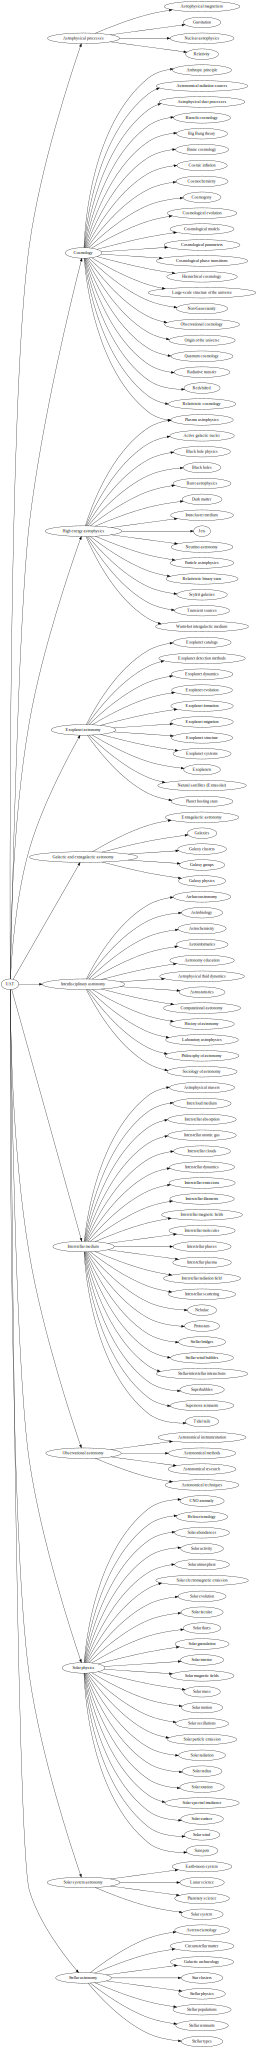

In [8]:
from anytree.exporter import DotExporter
import graphviz

# anytree provides an easy way to create DOT syntax for our tree (we want only the first 3 levels, and we want a left-right tree)
exporter = DotExporter(tree, maxlevel=3, options=["rankdir=LR"])

# Unfortunately, it doesn't provide a good way to render the tree inside of Jupyter. But we can use the graphviz package for that

# Remove duplicate links by converting to a unique list, then joining back together with \n. In Python 3.7+ this _will_ keep order!
source = "\n".join(list(dict.fromkeys(exporter)))
# Useful for debugging
# print(source)
# We can now send our raw source to graphviz, and render the result below
quick_look_dot = graphviz.Source(source, engine="dot")
quick_look_dot

Each node looks simple, but in fact it retains the full set of attributes from the UAT

In [9]:
# Show all public attributes of one of the leaf nodes to demonstrate that it retains everything from the UAT JSON
{key: value for key, value in tree.leaves[-1].__dict__.items() if not key.startswith("_")}

{'name': 'Delta Scuti variable stars',
 'uri': 'http://astrothesaurus.org/uat/370',
 'altLabels': ['Dwarf Cepheids', 'Al Velorum stars', 'Delta Scuti variables'],
 'related': None,
 'changeNotes': None,
 'scopeNotes': None,
 'examples': None,
 'definition': 'A member of a class of pulsating stars with periods less than 0.3 days, spectral types A or F, and visual light amplitudes in the range from a few thousands of a magnitude to about 0.8 mag. On the H-R diagram, δ Scuti stars form a group which lies in an instability strip which includes the classical Cepheids at its brightest end and the pulsating white dwarfs at its faintest limit. These stars can show very complex light variations since, while some of them are pulsating in one radial mode only, others may be pulsating simultaneously in several radial and non-radial modes.',
 'editorialNotes': [{'title': 'Definition Provenance',
   'comment': 'An Etymological Dictionary of Astronomy and Astrophysics, by M. Heydari-Malayeri'}]}

## Matching UAT Entries to Paper Keywords

Now we have both a tree structure representing the UAT, and a DataFrame representing all the GBT papers in ADS. The next step is to match them together.

We can do about 10% better if we use "fuzzy" string comparisons (with a threshold of 90% similarity). This is a very deep topic, but as a simple example: _we_ know that "star: formation" and "Star Formation" refer to the same concepts. These would be considered different concepts if we just did exact string comparisons (even with case insensitivity), but with fuzzy matching these are considered the same, as we expect.

We are using [RapidFuzz](https://github.com/maxbachmann/RapidFuzz) to perform the fuzzy comparisons

The 90% threshold is empirically derived -- it's low enough to be somewhat helpful, but high enough to avoid any false positives

In [10]:
from anytree import PreOrderIter
from rapidfuzz import process, fuzz
from tqdm import tqdm

# Generate a set of all unique keywords in our papers table. Note that we convert to lowercase to avoid (some) duplicates
unique_keywords_from_gbt_papers = set(keyword.lower() for keyword in papers.keyword.unique() if keyword)
print(f"There are {len(unique_keywords_from_gbt_papers)} unique keywords across our GBT papers")

# Generate a set of all unique entries in the UAT. Note that we preserve case here; we trust UAT to have resolved duplicates, and we need the exact case for later
unique_thesaurus_entries = set(node.name for node in PreOrderIter(tree) if node.name)
print(f"There are {len(unique_thesaurus_entries)} unique entries in the UAT")

# A set of (title, bibcode) tuples -- necessary to avoid issues with duplicate titles
matched_papers = set()
results = []
# The similarity threshold under which we discard matches
threshold = 90
for keyword in tqdm(unique_keywords_from_gbt_papers, unit="keyword"):  
    # Use the "basic" scorer -- this is fairly strict, and avoids issues with substring matches
    closest_thesaurus_entry, distance, __ = process.extractOne(keyword, unique_thesaurus_entries, scorer=fuzz.ratio)
    # Keep only if we hit the threshold
    if distance >= threshold:
        results.append((distance, keyword, closest_thesaurus_entry))
        papers_for_keyword = papers[papers["keyword"].str.lower() == keyword]
        # Create a generator of tuples of (title, bibcode) and add them all to the set
        matched_papers.update(zip(list(papers_for_keyword["title"]), list(papers_for_keyword["bibcode"])))

# Generate a set of _all_ papers' (title, bibcode)
all_papers = set(zip(list(papers["title"]), list(papers["bibcode"])))
# Determine the difference between this set and our matched papers (i.e. generate a set of unmatched papers)
unmatched_papers = all_papers.difference(matched_papers)
# Determine our matching percentage
print(f"{len(matched_papers)=} / {len(papers.bibcode.unique())=} = {len(matched_papers)/len(papers.bibcode.unique()):.1%}")
print(f"{len(unmatched_papers)=}")

There are 1443 unique keywords across our GBT papers
There are 2124 unique entries in the UAT


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1443/1443 [00:02<00:00, 716.69keyword/s]

len(matched_papers)=381 / len(papers.bibcode.unique())=831 = 45.8%
len(unmatched_papers)=450


In [11]:
sorted_results = sorted(results, reverse=True)
example_full_matches = sorted_results[:3]
example_partial_matches = sorted_results[-3:]

print(f"Some examples of exact matches: {example_full_matches}")
print(f"Some examples of partial matches: {example_partial_matches}")

Some examples of exact matches: [(100.0, 'zenith', 'Zenith'), (100.0, 'x ray sources', 'X-ray sources'), (100.0, 'x ray astronomy', 'X-ray astronomy')]
Some examples of partial matches: [(90.9090909090909, 'shock', 'Shocks'), (90.9090909090909, 'calibrating', 'Calibration'), (90.0, 'subdwarfs', 'L subdwarfs')]


In [12]:
import anytree

# For every match_result...
for __, gbt_paper_keyword, uat_entry in results:
    # ...find all matching entries in the UAT
    nodes = anytree.search.findall(tree, filter_=lambda node: node.name == uat_entry)
    # For each matching UAT entry...
    for node in nodes:
        # ...select all of the papers with this keyword...
        papers_for_keyword = papers[papers["keyword"].str.lower() == gbt_paper_keyword]
        # ...and parse them into a generator of tuples of (title, bibcode)
        bibcodes_of_papers_matching_keyword = zip(list(papers_for_keyword["title"]), list(papers_for_keyword["bibcode"]))
        if hasattr(node, "gbt_papers"):
            # If the node in our UAT tree already has a gbt_papers attribute, we assume it's a set and update it with new matches
            node.gbt_papers.update(bibcodes_of_papers_matching_keyword)
        else:
            # If the node doesn't yet have gbt_papers, we create a new set at this attribute
            node.gbt_papers = set(bibcodes_of_papers_matching_keyword)

## Visualizing the Results

At this point we have a tree representing the UAT hierarchy. Each node either holds a `gbt_papers` attribute, which is a set of all GBT papers that this entry is matched to, or it doesn't, in which case it has no matches

We don't care about the non-matching nodes, so we will now prune them out of the tree. _But_ we need to keep non-matching nodes _if_ they have children that are matching nodes!

But that's not particularly helpful still -- we haven't addressed our original question.

In [13]:
import anytree

nodes_to_prune = []
# Walk through the whole tree, from the _bottom up_!
for node in anytree.PostOrderIter(tree):
    # If the node has no papers...
    if not hasattr(node, "gbt_papers"):
        children_that_are_matching_nodes = anytree.search.findall(node, filter_=lambda n: hasattr(n, "gbt_papers"))
        # ...AND none of its children have papers...
        if not children_that_are_matching_nodes:
            # ...then mark it for deletion
            nodes_to_prune.append(node)
        # useful for debugging
        # else:
        #     print(f"was going to prune {node.name!r} but thought of its {len(node.children)} children")
        

# Do this separately; seems like it's bad to modify the tree during iteration
for node in nodes_to_prune:
    node.parent = None

In [16]:
from anytree.exporter.dotexporter import DotExporter
import anytree
import graphviz

import hashlib

# Generate a list of all UAT entries (not just a unique set this time)
all_thesaurus_entries = [node.name for node in PreOrderIter(tree) if node.name]

def get_node_attr(node):
    """Generate DOT attributes for given node"""
    total_papers = 0
    for child in anytree.PreOrderIter(node):
        total_papers += len(getattr(child, 'gbt_papers', set()))
    gbt_papers = getattr(node, 'gbt_papers', set())
    stub = f"{node.name}"
    if total_papers:
        if len(gbt_papers) != total_papers:
            paper_stub = f"\n{len(gbt_papers)} ({total_papers} total)"
        else:
            paper_stub = f": {len(gbt_papers)}"
        stub=f"{stub}{paper_stub}"
    stub = f'label="{stub}"'
    
    # If there are no GBT papers matched, light grey
    if not len(gbt_papers):
        stub = f'{stub} style="filled" color="lightgrey"'
    # If there are more than 1 entry, we want to indicate the duplicate somehow
    elif all_thesaurus_entries.count(node.name) > 1:
        duplicates = anytree.search.findall(tree, filter_=lambda n: n.name == node.name)
        nearest_common_ancestor = anytree.util.commonancestors(*duplicates)[-1]
        # print(f"{nearest_common_ancestor=}")
        # If the nearest common ancestor is the root of the tree, dark pink
        if nearest_common_ancestor == tree:
            stub = f'{stub} style="filled" color="#fdc1c5"'
        # If the nearest common ancestor is something else, light pink
        else:
            stub = f'{stub} style="filled" color="#fff4f2"'
            
        
    return stub
    
def get_node_name(node):
    return hash((node, node.parent))

# Export to DOT, using our above custom name and attribute derivation functions
exporter = DotExporter(tree, nodenamefunc=get_node_name, nodeattrfunc=get_node_attr, options=["rankdir=LR"])

# Convert to dict. In 3.7+ this _will_ keep order
source = "\n".join(list(dict.fromkeys(exporter)))

# Useful for debugging
# print(source)
foo = graphviz.Source(source, engine="dot")
output_path = foo.render(filename="gbt_paper_counts_per_uat_term", format="svg")

print(f"Wrote output to {output_path}")
# This will render the graph directly below, but it's so big at this point that it isn't very useful
# foo

Wrote output to gbt_paper_counts_per_uat_term.svg


At this point you should probably the SVG from above in your web browser -- this will provide a good way to scroll around and examine it. What are we looking at?

- White nodes: A UAT term that has been matched to one or more GBT papers (via one of the papers' keywords in ADS). A match count for that specific term, and for that term and all of its children, are also indicated
- Grey nodes: A UAT term that was _not_ matched to any GBT papers, but that has children that were. We have to keep these nodes in order to maintain links to the children
- Dark pink nodes: A UAT term that appears under one or more _distinct_ "astronomy categories". Technically, these nodes's nearest ancestor is the root of the tree -- this means that they aren't related under a more specific category like "solar astronomy"
- Light pink nodes: A UAT term that appears on multiple branches, but that exists only in a _single_ high-level astronomy category

In [17]:
# Write our tree to disk as JSON, in case we want to visualize it with something other than Graphviz later
from anytree.exporter import JsonExporter

for node in anytree.PreOrderIter(tree):
    if hasattr(node, "gbt_papers"):
        node.gbt_papers = sorted(node.gbt_papers)

exporter = JsonExporter()
with open("./final_tree.json", "w") as file:
    exporter.write(tree, file)

## Analysis

### Match Rate

We end up with ~45% match rate. This is a bit better than our naive match rate, but still doesn't seem _great_. However, if we look through the list of all GBT paper keywords, we can quickly see that many of them we have no hope of matching to the UAT. For example, lots of papers seem to indicate astronomical object names as keywords -- these will never match. So it's not clear what the actual upper bound of the match rate is -- this would require manual matching.

### Utility of the UAT for Our Goal

It's also worth considering the overall utility of the UAT for our original goal: matching GBT paper keywords to high level astronomical concepts. 

We can see that there are several pink and light pink nodes in our final tree. We'll use "Astronomy Databases" as an example.

Every GBT paper that has "astronomy databases" as a keyword is being matched to every single instance of the "Astronomy Databases" UAT term. In the context of the UAT, we know which category each of these terms is, via their ancestry in the tree. However, when actually matching, we are not considering this at all. Further, I'm not really sure _how_ this could reasonably be considered in any generic way -- how are we to know whether a GBT paper with "astronomy databases" as a key word is in "solar" astronomy or some other branch altogether?

There are two potential paths forward:

1. Make our matching algorithm smarter. Again, not sure how to do this
1. Delete these nodes from the tree altogether. This would avoid inflation of the overall paper counts

### Next Steps

I don't think there's a whole lot farther we can go without taking the time to make manual mappings of keywords to astronomy categories. Certainly that's the only way we could evaluate the performance of our matching algorithm. It might be the case that after one round of manual mappings, we discover that the automated algorithm is good enough to avoid manual mappings in the future (of course we would still have to map new terms that we haven't seen before)